In [160]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import sqlite3 as sq
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

from prettytable import PrettyTable


In [84]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [85]:
conn = sq.connect("drive/MyDrive/Match Outcome Prediction/database.sqlite")

In [86]:
player_data = pd.read_sql("SELECT * FROM Player;", conn)
player_stats_data = pd.read_sql("SELECT * FROM Player_Attributes;", conn)
team_data = pd.read_sql("SELECT * FROM Team;", conn)
match_data = pd.read_sql("SELECT * FROM Match;", conn)

In [88]:
league_id = 21518 # 1729, 4769, 7809, 10257, 21518

match_data = match_data[(match_data["league_id"] == league_id)]

In [89]:
def get_player_rating(player_api_id, player_stats_data):

    years = [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]

    player_stats = player_stats_data[(player_stats_data["player_api_id"] == player_api_id)]

    player_info = {
        "yearly": {},
    }

    min_rating, max_rating = 101, -1

    for year in years:

        player_ratings = player_stats[player_stats.date.str.match(str(year) + ".*")]["overall_rating"].tolist()
        player_ratings = [x for x in player_ratings if np.isnan(x) == False]
        player_info["yearly"][year] = sum(player_ratings) / len(player_ratings) if len(player_ratings) > 0 else None

        for rating in player_ratings:

            min_rating = rating if rating < min_rating else min_rating
            max_rating = rating if rating > max_rating else max_rating

    player_info["min"] = min_rating
    player_info["max"] = max_rating

    return player_info

player_info = {}
min_rating, max_rating = 100, 0

for match in range(match_data.shape[0]):

    for player in range(1, 12):

        player_api_id = match_data[f"home_player_{player}"].values[match]
      
        if player_api_id not in list(player_info.keys()):

            player_info[player_api_id] = get_player_rating(player_api_id, player_stats_data)
            min_rating = player_info[player_api_id]["min"] if player_info[player_api_id]["min"] < min_rating else min_rating
            max_rating = player_info[player_api_id]["max"] if player_info[player_api_id]["max"] > max_rating else max_rating

        player_api_id = match_data[f"away_player_{player}"].values[match]

        if player_api_id not in list(player_info.keys()):

            player_info[player_api_id] = get_player_rating(player_api_id, player_stats_data)
            min_rating = player_info[player_api_id]["min"] if player_info[player_api_id]["min"] < min_rating else min_rating
            max_rating = player_info[player_api_id]["max"] if player_info[player_api_id]["max"] > max_rating else max_rating

for player_api_id in list(player_info.keys()):

    for year in list(player_info[player_api_id]["yearly"].keys()):

        player_info[player_api_id]["yearly"][year] = (player_info[player_api_id]["yearly"][year] - min_rating) / (max_rating - min_rating) if player_info[player_api_id]["yearly"][year] is not None else None

    player_info[player_api_id]["min"] = (player_info[player_api_id]["min"] - min_rating) / (max_rating - min_rating) if player_info[player_api_id]["min"] is not -1 else None
    player_info[player_api_id]["max"] = (player_info[player_api_id]["max"] - min_rating) / (max_rating - min_rating) if player_info[player_api_id]["max"] is not 101 else None

In [97]:
def get_match_data(data, match_api_id, match_data, player_info):

    home_team_api_id = match_data[(match_data["match_api_id"] == match_api_id)]["home_team_api_id"].values[0]
    away_team_api_id = match_data[(match_data["match_api_id"] == match_api_id)]["away_team_api_id"].values[0]
    season = match_data[(match_data["match_api_id"] == match_api_id)]["season"].values[0]
    stage = match_data[(match_data["match_api_id"] == match_api_id)]["stage"].values[0]

    home_team_goal = match_data[(match_data["match_api_id"] == match_api_id)]["home_team_goal"].values[0]
    away_team_goal = match_data[(match_data["match_api_id"] == match_api_id)]["away_team_goal"].values[0]

    if home_team_goal > away_team_goal:

        result = 0

    elif home_team_goal < away_team_goal:

        result = 2

    else:

        result = 1

    home_team_home_match_data = match_data[(match_data["home_team_api_id"] == home_team_api_id) & (match_data["season"] == season) & (match_data["stage"] < stage)]
    home_team_away_match_data = match_data[(match_data["away_team_api_id"] == home_team_api_id) & (match_data["season"] == season) & (match_data["stage"] < stage)]
    away_team_home_match_data = match_data[(match_data["home_team_api_id"] == away_team_api_id) & (match_data["season"] == season) & (match_data["stage"] < stage)]
    away_team_away_match_data = match_data[(match_data["away_team_api_id"] == away_team_api_id) & (match_data["season"] == season) & (match_data["stage"] < stage)]

    alpha = 0.6
    home_team_sentiment, away_team_sentiment = 0, 0

    for match in range(home_team_home_match_data.shape[0]):

        stage_ = home_team_home_match_data["stage"].values[match]
        win = 1 if home_team_home_match_data["home_team_goal"].values[match] > home_team_home_match_data["away_team_goal"].values[match] else 0
        lost = -1 if home_team_home_match_data["home_team_goal"].values[match] < home_team_home_match_data["away_team_goal"].values[match] else 0
        home_team_sentiment += (win + lost) * alpha ** (stage - stage_)
 
    for match in range(home_team_away_match_data.shape[0]):

        stage_ = home_team_away_match_data["stage"].values[match]
        win = 1 if home_team_away_match_data["home_team_goal"].values[match] < home_team_away_match_data["away_team_goal"].values[match] else 0
        lost = -1 if home_team_away_match_data["home_team_goal"].values[match] > home_team_away_match_data["away_team_goal"].values[match] else 0
        home_team_sentiment += (win + lost) * alpha ** (stage - stage_)

    for match in range(away_team_home_match_data.shape[0]):

        stage_ = away_team_home_match_data["stage"].values[match]
        win = 1 if away_team_home_match_data["home_team_goal"].values[match] > away_team_home_match_data["away_team_goal"].values[match] else 0
        lost = -1 if away_team_home_match_data["home_team_goal"].values[match] < away_team_home_match_data["away_team_goal"].values[match] else 0
        away_team_sentiment += (win + lost) * alpha ** (stage - stage_)

    for match in range(away_team_away_match_data.shape[0]):

        stage_ = away_team_away_match_data["stage"].values[match]
        win = 1 if away_team_away_match_data["home_team_goal"].values[match] < away_team_away_match_data["away_team_goal"].values[match] else 0
        lost = -1 if away_team_away_match_data["home_team_goal"].values[match] > away_team_away_match_data["away_team_goal"].values[match] else 0
        away_team_sentiment += (win + lost) * alpha ** (stage - stage_)

    home_team_rating, away_team_rating = 0, 0

    for player in range(1, 12):

        player_api_id = match_data[(match_data["match_api_id"] == match_api_id)][f"home_player_{player}"].values[0]

        if player_api_id in list(player_info.keys()):

            player_score = player_info[player_api_id]["yearly"][int(season.split("/")[0])]
            player_score = player_score if player_score is not None else 0.5

        else:

            player_score = 0.5

        home_team_rating += player_score

        player_api_id = match_data[(match_data["match_api_id"] == match_api_id)][f"away_player_{player}"].values[0]
        
        if player_api_id in list(player_info.keys()):

            player_score = player_info[player_api_id]["yearly"][int(season.split("/")[0])]
            player_score = player_score if player_score is not None else 0.5

        else:

            player_score = 0.5

        away_team_rating += player_score

    home_team_rating = home_team_rating / 11
    away_team_rating = away_team_rating / 11

    sentiment_difference = home_team_sentiment - away_team_sentiment
    rating_difference = home_team_rating - away_team_rating

    data["sentiment_difference"].append(sentiment_difference)
    data["rating_difference"].append(rating_difference)
    data["result"].append(result)

    return data

data = {
    "sentiment_difference": [],
    "rating_difference": [],
    "result": []
}

for match in range(match_data.shape[0]):

    match_api_id = match_data["match_api_id"].values[match]

    data = get_match_data(data, match_api_id, match_data, player_info)

data = pd.DataFrame(data)

In [193]:
X = data.drop(columns=["result"])
Y = data["result"]

for column in X.columns:

    X[column] = (X[column] - X[column].min()) / (X[column].max() - X[column].min())    

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15)

In [198]:
classifier = KNeighborsClassifier()

model = classifier.fit(X_train, Y_train)

train_score = model.score(X_train, Y_train)
test_score = model.score(X_test, Y_test)

Y_test_pred = model.predict(X_test)

test_confusion_matrix = confusion_matrix(Y_test, Y_test_pred, normalize="true")

In [199]:
x = PrettyTable(["Train Accuracy", "Test Accuracy"])

x.add_row([f"{round(train_score * 100, 1)} %", f"{round(test_score * 100, 1)} %"])

print(x)

+----------------+---------------+
| Train Accuracy | Test Accuracy |
+----------------+---------------+
|     64.2 %     |     52.0 %    |
+----------------+---------------+


Text(69.0, 0.5, 'True')

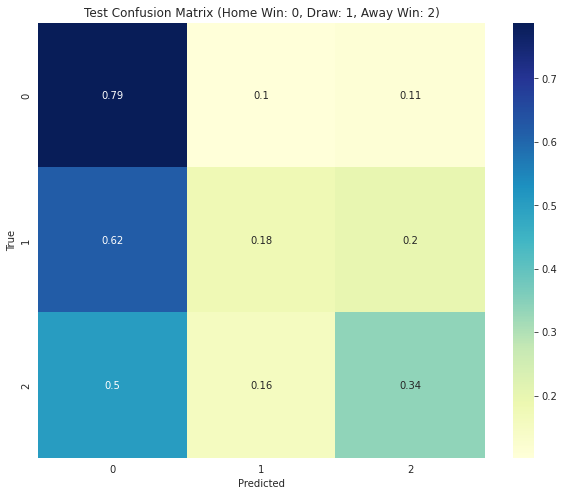

In [200]:
plt.figure(figsize=(10,8))

sns.set_style("darkgrid")
sns.set_palette("Set2")
sns.heatmap(test_confusion_matrix, annot=True, cmap="YlGnBu")

plt.title("Test Confusion Matrix (Home Win: 0, Draw: 1, Away Win: 2)")
plt.xlabel("Predicted")
plt.ylabel("True")